## Image Augmentation and STEP LR Fine tunning Version 5
# Target:
####  Apply Image Augmentation and LR Fine tunning
* Image augmentation - Random rotation of in the range of -10 to 10 degrees and fill with 1
* Step LR with Learning Rate = 0.1, Step Size = 9 and Gamma = 0.18

### Results:

* Parameters: 5,893
* Best Train Accuracy: 99.26%
* Best Test Accuracy: 99.44%

**Analysis:**
- Image Augmentation with random rotation of -10 to 10 degrees helped to overcome overfitting issues.
- Step LR with Learning Rate of 0.1 and Step Size of 9 and Gamma of 0.18 helped to achieve consistency with model results.  
- Finally objective achieved with test accuracy of 99.44% with parameter less than 8K.


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import matplotlib.pyplot as plt

## Data Transformations



In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.40MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders



In [4]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# The Model Architecture


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # INPUT BLOCK
        # First convolution layer to process input image
        # Input: 28x28x1 | Output: 26x26x7
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),  # Activation function
            nn.BatchNorm2d(num_features=7)  # Normalize the features
        )

        # CONVOLUTION BLOCK 1
        # Increase feature maps and reduce spatial dimensions
        # Input: 26x26x7 | Output: 24x24x14
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14)
        )

        # First pooling layer to reduce spatial dimensions
        # Input: 24x24x14 | Output: 12x12x14
        self.pool1 = nn.MaxPool2d(2, 2)

        # Reduce channels while maintaining spatial information
        # Input: 12x12x14 | Output: 10x10x7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=7)
        )

        # TRANSITION BLOCK 1
        # Note: pool1 is defined twice - this might be a bug in the original code
        # Second pooling operation
        # Input: 10x10x7 | Output: 5x5x7
        self.pool1 = nn.MaxPool2d(2, 2)

        # 1x1 convolution to increase channels without affecting spatial dimensions
        # Input: 5x5x7 | Output: 5x5x14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=14)
        )

        # CONVOLUTION BLOCK 2
        # Further feature extraction with increased channels
        # Input: 5x5x14 | Output: 3x3x28
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=28)
        )

        # OUTPUT BLOCK
        # 1x1 convolution to reduce channels to match number of classes
        # Input: 3x3x28 | Output: 3x3x10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=10)
        )

        # Global average pooling to reduce spatial dimensions
        # Input: 3x3x10 | Output: 1x1x10
        self.convblock7 = nn.Sequential(
            nn.AvgPool2d(kernel_size=(3,3))
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.convblock1(x)  # Initial feature extraction
        x = self.convblock2(x)  # Increase feature maps
        x = self.pool1(x)       # Reduce spatial dimensions
        x = self.convblock3(x)  # Channel reduction
        x = self.pool1(x)       # Further spatial reduction
        x = self.convblock4(x)  # Channel increase with 1x1 conv
        x = self.convblock5(x)  # Deep feature extraction
        x = self.convblock6(x)  # Reduce to number of classes
        x = self.convblock7(x)  # Global average pooling
        x = x.view(-1, 10)      # Flatten to (batch_size, num_classes)
        return F.log_softmax(x, dim=-1)  # Apply log softmax for classification

# Model Params

In [6]:
!pip install torchsummary

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              63
              ReLU-2            [-1, 7, 26, 26]               0
       BatchNorm2d-3            [-1, 7, 26, 26]              14
            Conv2d-4           [-1, 14, 24, 24]             882
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
         MaxPool2d-7           [-1, 14, 12, 12]               0
            Conv2d-8            [-1, 7, 10, 10]             882
              ReLU-9            [-1, 7, 10, 10]               0
      BatchNorm2d-10            [-1, 7, 10, 10]              14
        MaxPool2d-11              [-1, 7, 5, 5]               0
           Conv2d-12             [-1, 14, 5, 5]              98
             ReLU-13             [-1, 14, 5, 5]               0
      BatchNorm2d-14             [

# Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model


In [9]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=9, gamma=0.18)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after epoch {epoch}: {current_lr:.6f}")

EPOCH: 0


Loss=0.08583343774080276 Batch_id=468 Accuracy=94.43: 100%|██████████| 469/469 [00:41<00:00, 11.22it/s]



Test set: Average loss: 0.0528, Accuracy: 9855/10000 (98.55%)

Learning Rate after epoch 0: 0.100000
EPOCH: 1


Loss=0.08458155393600464 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:34<00:00, 13.54it/s]



Test set: Average loss: 0.0743, Accuracy: 9769/10000 (97.69%)

Learning Rate after epoch 1: 0.100000
EPOCH: 2


Loss=0.028237292543053627 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:35<00:00, 13.24it/s]



Test set: Average loss: 0.0366, Accuracy: 9892/10000 (98.92%)

Learning Rate after epoch 2: 0.100000
EPOCH: 3


Loss=0.03169940412044525 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:34<00:00, 13.51it/s]



Test set: Average loss: 0.0353, Accuracy: 9884/10000 (98.84%)

Learning Rate after epoch 3: 0.100000
EPOCH: 4


Loss=0.04062960669398308 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:35<00:00, 13.34it/s]



Test set: Average loss: 0.0362, Accuracy: 9889/10000 (98.89%)

Learning Rate after epoch 4: 0.100000
EPOCH: 5


Loss=0.0023161014541983604 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s]



Test set: Average loss: 0.0277, Accuracy: 9919/10000 (99.19%)

Learning Rate after epoch 5: 0.100000
EPOCH: 6


Loss=0.03165089711546898 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s]



Test set: Average loss: 0.0284, Accuracy: 9904/10000 (99.04%)

Learning Rate after epoch 6: 0.100000
EPOCH: 7


Loss=0.02452966384589672 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:35<00:00, 13.11it/s]



Test set: Average loss: 0.0289, Accuracy: 9899/10000 (98.99%)

Learning Rate after epoch 7: 0.100000
EPOCH: 8


Loss=0.004622164182364941 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]



Test set: Average loss: 0.0294, Accuracy: 9905/10000 (99.05%)

Learning Rate after epoch 8: 0.018000
EPOCH: 9


Loss=0.01862012967467308 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]



Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)

Learning Rate after epoch 9: 0.018000
EPOCH: 10


Loss=0.031150558963418007 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:36<00:00, 13.01it/s]



Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)

Learning Rate after epoch 10: 0.018000
EPOCH: 11


Loss=0.013176173903048038 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]



Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

Learning Rate after epoch 11: 0.018000
EPOCH: 12


Loss=0.060165371745824814 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]



Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)

Learning Rate after epoch 12: 0.018000
EPOCH: 13


Loss=0.05688154697418213 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:35<00:00, 13.15it/s]



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

Learning Rate after epoch 13: 0.018000
EPOCH: 14


Loss=0.01766630820930004 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:35<00:00, 13.18it/s]



Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)

Learning Rate after epoch 14: 0.018000


Text(0.5, 1.0, 'Test Accuracy')

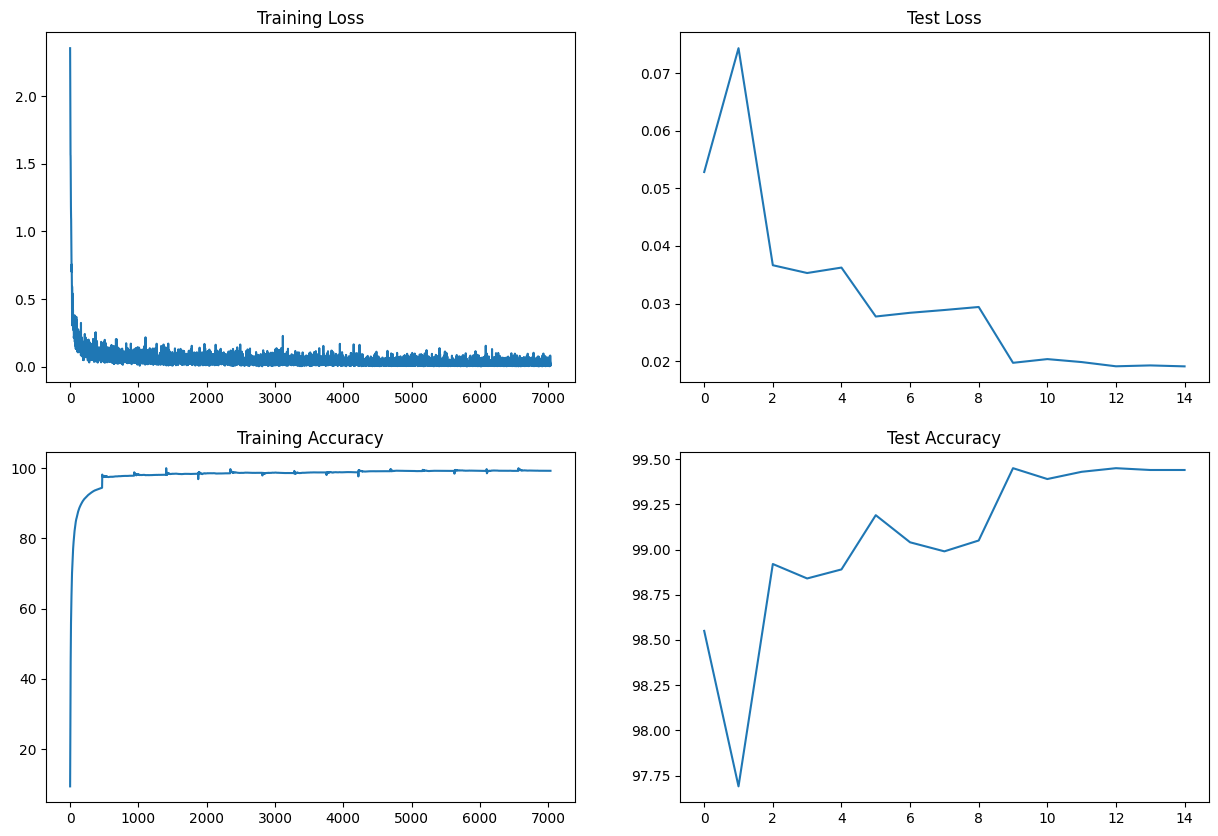

In [11]:
# Commented out IPython magic to ensure Python compatibility.
t = [t_items.item() for t_items in train_losses]
# %matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")